In [ ]:
!pip -q install scikit-learn matplotlib pandas

In [ ]:
# --- Imports & Reproducibility ---
import os
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, average_precision_score, roc_curve
)

import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [ ]:
# --- Load data ---
DATA_PATH = "Churn_Modelling.csv"
assert os.path.exists(DATA_PATH), f"Cannot find {DATA_PATH}. Place it next to this notebook."

df = pd.read_csv(DATA_PATH)
display(df.head())
print("Shape:", df.shape)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Shape: (10000, 14)


## Quick sanity checks

We verify:
- target column exists (`Exited`)
- class balance (churn rate)
- missing values


In [ ]:
# Target distribution (class imbalance check)
assert "Exited" in df.columns, "Expected target column 'Exited' not found."

churn_rate = df["Exited"].mean()
print(f"Churn rate (Exited=1): {churn_rate:.3f}")

# Missing values
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values (top):")
print(missing.head(10))

# Basic column info
print("\nColumns:")
print(df.columns.tolist())


Churn rate (Exited=1): 0.204

Missing values (top):
RowNumber        0
CustomerId       0
Surname          0
CreditScore      0
Geography        0
Gender           0
Age              0
Tenure           0
Balance          0
NumOfProducts    0
dtype: int64

Columns:
['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


## Feature selection & preprocessing

We drop ID-like columns that should not help generalization:
- `RowNumber`, `CustomerId`, `Surname`

We use:
- One-Hot Encoding for `Geography` and `Gender` (robust and deployable)
- Standard scaling for numeric features

All preprocessing is done inside a **single Pipeline** to avoid leakage.


In [ ]:
# --- Define features/target ---
drop_cols = ["RowNumber", "CustomerId", "Surname"]
X = df.drop(columns=drop_cols + ["Exited"])
y = df["Exited"].astype(int)

# Identify column types
categorical_cols = [c for c in ["Geography", "Gender"] if c in X.columns]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

# Preprocessor: OneHot + Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# Stratified split (important with imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train churn rate:", y_train.mean(), " Test churn rate:", y_test.mean())


Categorical: ['Geography', 'Gender']
Numeric: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Train size: (8000, 10)  Test size: (2000, 10)
Train churn rate: 0.20375  Test churn rate: 0.2035


## Build an ANN model (Keras)

Design choices:
- Slightly larger network than the original (tabular data benefits from more capacity)
- BatchNorm + Dropout to improve generalization
- EarlyStopping on validation AUC (restore best weights)
- ReduceLROnPlateau to refine learning rate


In [ ]:
# --- Build model factory ---
def build_model(input_dim: int) -> tf.keras.Model:
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),

        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),

        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )
    return model

# Pre-fit the preprocessor to get input dimension
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Processed feature dimension:", X_train_proc.shape[1])

model = build_model(X_train_proc.shape[1])
model.summary()


Processed feature dimension: 13


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 192 (768.00 B)

## Train with validation + callbacks

We use `validation_split=0.2` from the training set for early stopping.

> If you want maximum rigor, use a separate validation split or cross-validation.


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=10, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5
    ),
]

history = model.fit(
    X_train_proc, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5634 - auc: 0.5687 - loss: 0.8115 - precision: 0.2463 - recall: 0.5199 - val_accuracy: 0.8275 - val_auc: 0.7788 - val_loss: 0.5567 - val_precision: 0.6028 - val_recall: 0.4031 - learning_rate: 0.0010
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7217 - auc: 0.7008 - loss: 0.5529 - precision: 0.3782 - recall: 0.4961 - val_accuracy: 0.8425 - val_auc: 0.7979 - val_loss: 0.4565 - val_precision: 0.7361 - val_recall: 0.3313 - learning_rate: 0.0010
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7780 - auc: 0.7486 - loss: 0.4750 - precision: 0.4671 - recall: 0.3888 - val_accuracy: 0.8462 - val_auc: 0.8169 - val_loss: 0.3978 - val_precision: 0.7569 - val_recall: 0.3406 - learning_rate: 0.0010
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8021 - auc: 0.7652 - loss: 0.4445 - precision: 0.5466 - recall: 0.3459 - val_accuracy: 0.8494 - val_auc: 0.8279 - val_loss: 0.373

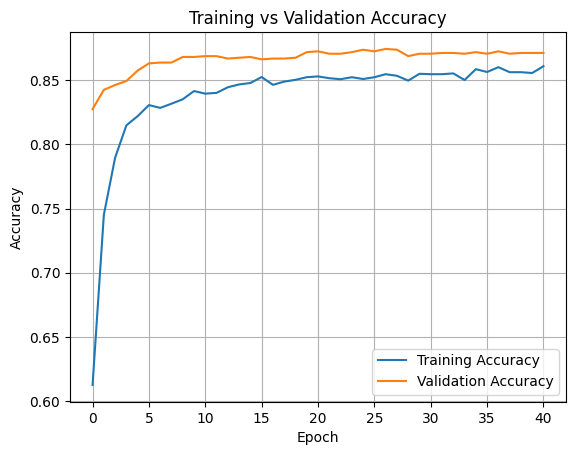

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

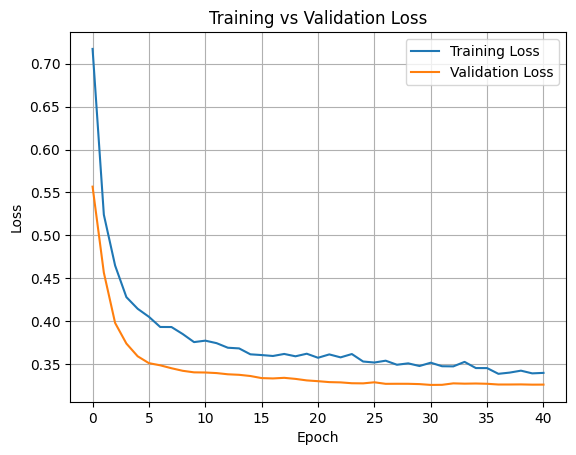

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Training curves

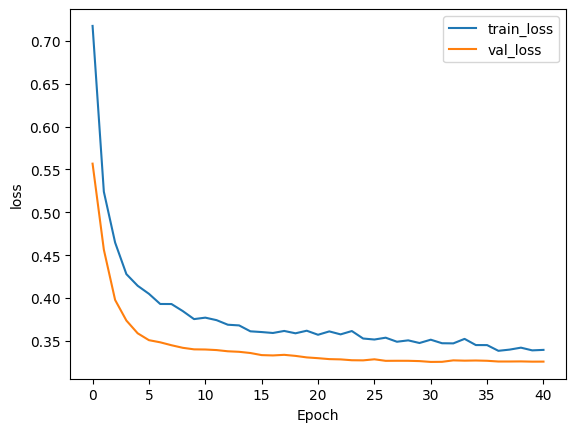

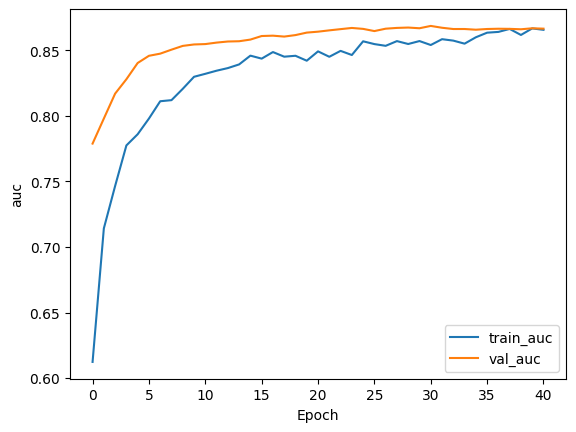

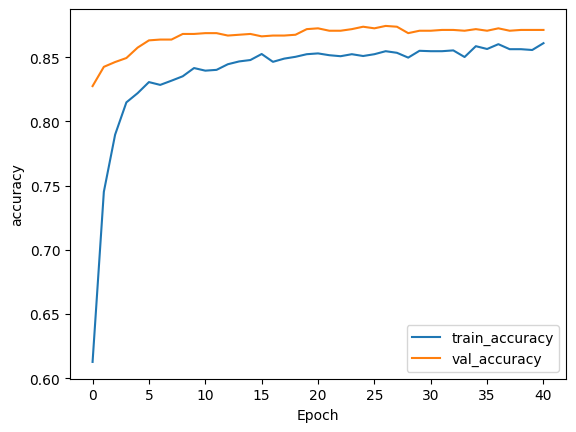

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, key):
    plt.figure()
    plt.plot(hist.history[key], label=f"train_{key}")
    plt.plot(hist.history[f"val_{key}"], label=f"val_{key}")
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.legend()
    plt.show()

for k in ["loss", "auc", "accuracy"]:
    if k in history.history and f"val_{k}" in history.history:
        plot_history(history, k)


## Evaluate on the test set

We report:
- ROC-AUC, PR-AUC
- Classification report at threshold 0.5
- Confusion matrix
- ROC and Precision-Recall curves


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test ROC-AUC: 0.8617
Test PR-AUC : 0.7081

--- Classification report @ threshold=0.50 ---
              precision    recall  f1-score   support

           0     0.8797    0.9636    0.9197      1593
           1     0.7725    0.4840    0.5952       407

    accuracy                         0.8660      2000
   macro avg     0.8261    0.7238    0.7574      2000
weighted avg     0.8579    0.8660    0.8537      2000

Confusion matrix @0.50:
 [[1535   58]
 [ 210  197]]


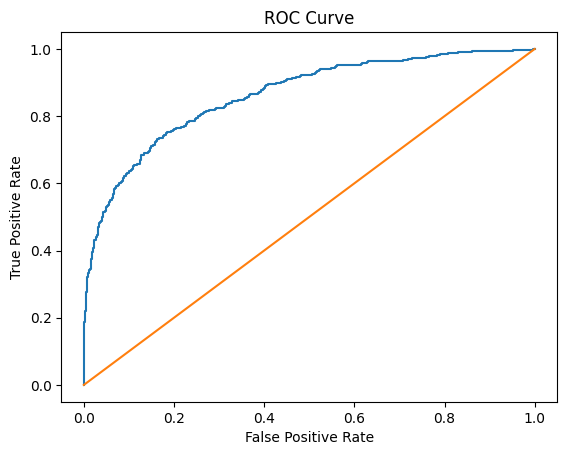

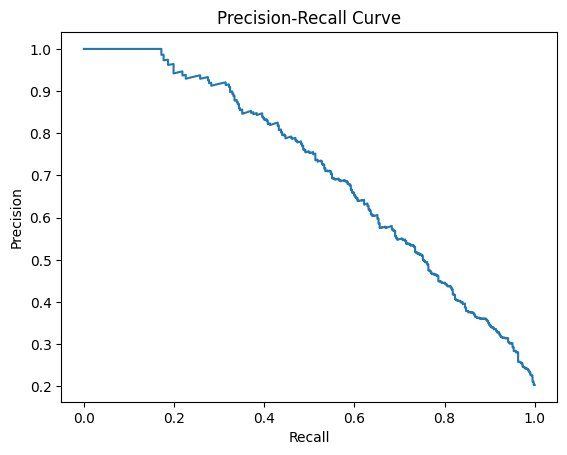

In [ ]:
# Predict probabilities
proba = model.predict(X_test_proc).ravel()

# AUC metrics
roc_auc = roc_auc_score(y_test, proba)
pr_auc = average_precision_score(y_test, proba)
print(f"Test ROC-AUC: {roc_auc:.4f}")
print(f"Test PR-AUC : {pr_auc:.4f}")

# Default threshold (0.5)
y_pred_05 = (proba >= 0.5).astype(int)
print("\n--- Classification report @ threshold=0.50 ---")
print(classification_report(y_test, y_pred_05, digits=4))

cm = confusion_matrix(y_test, y_pred_05)
print("Confusion matrix @0.50:\n", cm)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


## Threshold tuning (recommended)

Instead of hardcoding 0.5, we select a threshold that optimizes **F1** on the test set (for demonstration).

> In production, tune the threshold on a validation set to avoid using test labels for tuning.


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

prec, rec, thr = precision_recall_curve(y_test, proba)
# precision_recall_curve returns thresholds of length n-1
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)

best_idx = int(np.argmax(f1))
best_f1 = float(f1[best_idx])

# Map index to threshold; handle the extra point where threshold is undefined
if best_idx == len(thr):
    best_thr = 0.5
else:
    best_thr = float(thr[best_idx])

y_pred_best = (proba >= best_thr).astype(int)

print(f"Best F1 threshold (demo): {best_thr:.4f}")
print(f"Best F1: {best_f1:.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_best):.4f}")

print("\n--- Classification report @ tuned threshold ---")
print(classification_report(y_test, y_pred_best, digits=4))

print("Confusion matrix @tuned:\n", confusion_matrix(y_test, y_pred_best))


Best F1 threshold (demo): 0.3914
Best F1: 0.6317
Precision: 0.6770
Recall   : 0.5921

--- Classification report @ tuned threshold ---
              precision    recall  f1-score   support

           0     0.8990    0.9278    0.9132      1593
           1     0.6770    0.5921    0.6317       407

    accuracy                         0.8595      2000
   macro avg     0.7880    0.7600    0.7725      2000
weighted avg     0.8538    0.8595    0.8559      2000

Confusion matrix @tuned:
 [[1478  115]
 [ 166  241]]


## Optional: Logistic Regression baseline (fast, strong for tabular)

This is a useful comparison to confirm the ANN is actually adding value.


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=2000, class_weight="balanced")
baseline_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", logreg),
])

baseline_pipe.fit(X_train, y_train)
baseline_proba = baseline_pipe.predict_proba(X_test)[:, 1]

print("LogReg Test ROC-AUC:", roc_auc_score(y_test, baseline_proba))
print("LogReg Test PR-AUC :", average_precision_score(y_test, baseline_proba))

baseline_pred = (baseline_proba >= 0.5).astype(int)
print("\n--- LogReg classification report @0.50 ---")
print(classification_report(y_test, baseline_pred, digits=4))


LogReg Test ROC-AUC: 0.7771654551315569
LogReg Test PR-AUC : 0.46791921719038454

--- LogReg classification report @0.50 ---
              precision    recall  f1-score   support

           0     0.9035    0.7169    0.7994      1593
           1     0.3872    0.7002    0.4987       407

    accuracy                         0.7135      2000
   macro avg     0.6454    0.7086    0.6491      2000
weighted avg     0.7984    0.7135    0.7382      2000



## Save artifacts (optional)

- Save the ANN model
- Save the fitted preprocessing pipeline (sklearn)

This makes the notebook deployable without manually recreating encoders/scalers.


In [ ]:
import joblib

# Save ANN
model.save("churn_ann.keras")
print("Saved ANN to churn_ann.keras")

# Save preprocessor
joblib.dump(preprocessor, "churn_preprocessor.joblib")
print("Saved preprocessor to churn_preprocessor.joblib")


Saved ANN to churn_ann.keras
Saved preprocessor to churn_preprocessor.joblib
